### Objectives:
1) Create the training dataset based on the BMI & cost business rules. 

2) Develop a model to predict COST. The thinking process is more 
important than the actual model or model metrics.

3) Write steps to operationalize the model. 
Dataset: The data to be used is given in the zip folder as a csv file.

In the Dataset (Sample.csv), you are provided with 100 different applicant information describing 6 different 
attributes.

#### Variable Description 

AppID Anonymized Applicant ID 

Ins_Age Applicant Age

Ins_Gender Applicant Gender

Ht Height of the Applicant in Ft with Inches, The first digit 
refers to the ft and the following digits refers to the 
inches. For example, 507 means 5 ft and 7 inches.

Wt Weight of the Applicant in pounds.
Issue_Date Date of Application (Can be Null

In [1]:
from __future__ import annotations
from abc import ABC, abstractmethod

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline, FeatureUnion

### BASIC EDA

In [2]:
df_base = pd.read_csv("Dummy-Data.csv")
df_base.head()



,AppID,Ins_Age,Ins_Gender,Ht,Wt,IssueDate
0,56372,31,Male,510,185,NaN
1,34565,35,Male,510,205,NaN
2,57732,45,Female,510,125,NaN
3,87324,38,Male,503,175,NaN
4,12323,39,Female,600,252,NaN


In [3]:
# Renaming feature names for better consistency
df_base.rename(columns = {'AppID':'app_id', 
                'Ins_Age':'age', 
                'Ins_Gender':'gender', 
                'Ht': 'height',
                'Wt':'weight',
               'IssueDate':'issue_date'}, inplace=True)

In [4]:
df_base.describe()

,app_id,age,height,weight,issue_date
count,100.000000,100.000000,100.000000,100.00000,0.0
mean,79455.570000,37.320000,527.720000,165.15000,NaN
std,31123.726942,12.103827,39.482787,27.66224,NaN
min,12123.000000,19.000000,500.000000,110.00000,NaN
25%,64296.000000,27.750000,506.000000,145.00000,NaN
50%,99444.500000,36.000000,509.000000,170.00000,NaN
75%,99917.000000,47.000000,511.000000,180.00000,NaN
max,100345.000000,59.000000,605.000000,275.00000,NaN


In [5]:

corr = df_base.corr()
# plot the heatmap
corr.style.background_gradient(cmap='coolwarm')
#no strongly correlated features found, all features can be used to predict the bmi

C:\Users\91995\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\io\formats\style.py:1126: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
C:\Users\91995\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\io\formats\style.py:1127: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,app_id,age,height,weight,issue_date
app_id,1.000000,0.101992,-0.209433,-0.207522,nan
age,0.101992,1.000000,-0.016107,-0.078824,nan
height,-0.209433,-0.016107,1.000000,-0.040016,nan
weight,-0.207522,-0.078824,-0.040016,1.000000,nan
issue_date,nan,nan,nan,nan,nan


<AxesSubplot:>

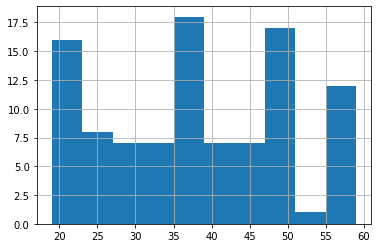

In [6]:
df_base['age'].hist()
# age of the people are distributed between 19 & below 60

<AxesSubplot:>

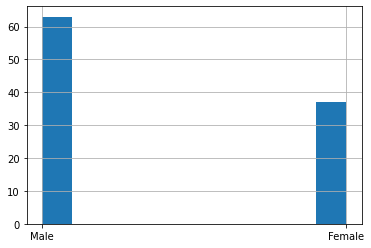

In [7]:
df_base['gender'].hist()
# dataset represents more data for male than female, which can be balanced on data augumentation to avoid bias towards male.

<AxesSubplot:>

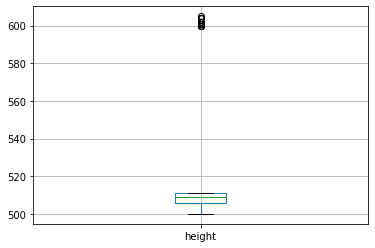

In [8]:
 df_base.boxplot(column=['height'])
#some outliers

<AxesSubplot:>

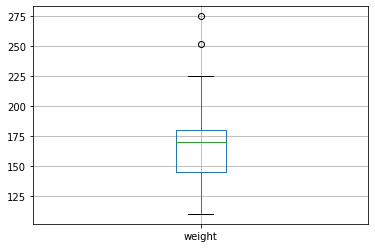

In [9]:
 df_base.boxplot(column=['weight'])
#outliers

### DATA Pre-Processing

State Behavioural design pattern is used to design the simple pipeline without using any sklearn's pipeline. States can be skipped or moved back & forth based on conditions, which gives great flexibility for extension.

Since there is no missing values or null data, Transformers is used convert Pounds to Kg, Inch to Meter Square & calculate BMI.
Later on, if we get any mixed metrics such as kg, pound, ounces, inches, feet, meter from different datasources, these trasformers can be extended or updated to support it.

In [10]:
#  file names used for the data source
class DataFile(object):
    SRC_F_NAME = "Dummy-Data.csv"
    INT_F_NAME = "Imputed-Data.csv"
    TRAIN_F_NAME = "Imputed-Data-Train.csv"
    TEST_F_NAME = "Imputed-Data-Test.csv"


class Imputer(ABC):

    @property
    def context(self) -> Context:
        return self._context

    @context.setter
    def context(self, context: Context) -> None:
        self._context = context

    @abstractmethod
    def impute():
        pass
    

    
class Context:
    # current state of the machine
    _state = None
    # holdstrain or test venvironment
    _env = None
    # true: train/test split is done, false: no split is done
    is_split = False
    # renamed features to be used in the train/test dataset
    FEATURES ={'KEY_ID':'app_id', 
                'KEY_AGE':'age', 
                'KEY_GENDER':'gender', 
                'KEY_HEIGHT': 'height',
                'KEY_WEIGHT':'weight',
                'KEY_ISSUE_DATE':'issue_date',
                'KEY_BMI':'bmi'}
    # name of the target feature
    TARGET = "cost"
    # holds the old & new name of all features
    FEATURES_OLD = {'AppID':FEATURES['KEY_ID'], 
                'Ins_Age':FEATURES['KEY_AGE'], 
                'Ins_Gender': FEATURES['KEY_GENDER'], 
                'Ht': FEATURES['KEY_HEIGHT'],
                'Wt': FEATURES['KEY_WEIGHT'],
               'IssueDate': FEATURES['KEY_ISSUE_DATE']}
    """
    A reference to the current state of the Context.
    """

    def __init__(self, state: Imputer, env = None) -> None:
        self.transition_to(state)
        self._env = env
        
    def transition_to(self, state: Imputer):
        """
        The Context allows changing the State object at runtime.
        """

        print(f"Context: Transition to {type(state).__name__}")
        self._state = state
        self._state.context = self
        
    # this should be moved to another class
    def split_df(self):
        '''
        Splits the dataset into train & test set, stores to csv files
        '''
        self.is_split = True
        df = pd.read_csv(DataFile.INT_F_NAME)
        df_train, df_test = train_test_split(df, test_size=0.2)
        df_train.to_csv(DataFile.TRAIN_F_NAME, index=False)
        df_test.to_csv(DataFile.TEST_F_NAME, index=False)
        
    # this should be moved to another class
    def read_csv(self) -> df:
        '''
            FNameImputer is the initial state on initializing the state machine.
            It returns the source csv file (DataFile.SRC_F_NAME)  
        '''
        if type(self._state).__name__ == "FNameImputer":
            df = pd.read_csv(DataFile.SRC_F_NAME)
            return df
        '''
            Until imputation, intermediate pre-processed csv file(DataFile.INT_F_NAME) is returned for 
            removing empty columns, renaming features & removing duplicate instances.
        '''
        
        if self.is_split == False:
            df = pd.read_csv(DataFile.INT_F_NAME)
            return df
        else:
            '''
            For Imputations such as feature transformations, impute missing values/categorical features, 
            splitted train & test data is returned/used.
            '''
            df_train = pd.read_csv(DataFile.TRAIN_F_NAME)
            df_test = pd.read_csv(DataFile.TEST_F_NAME)
            return df_train, df_test
    
    # this should be moved to another class
    def to_csv(self, df_train, df_test = None):
        # saves train, test & intermediate csv files to disk.
        if self.is_split == False:
            df_train.to_csv(DataFile.INT_F_NAME, index=False)
        else:
            df_train.to_csv(DataFile.TRAIN_F_NAME, index=False)
            df_test.to_csv(DataFile.TEST_F_NAME, index=False)
        
    def to_csvs(self, df_train, df_test):
        # saves train, test  csv files to disk.
        df_train.to_csv(DataFile.TRAIN_F_NAME, index=False)
        df_test.to_csv(DataFile.TEST_F_NAME, index=False)
       
    def remove_outliers(self):
        # removes outliers
        self._state.impute()
        
    def rename_features(self):
        # renames feature/column names
        self._state.impute()
    
    def impute_missing_values(self):
        # impute missing values
        self._state.impute()
        
    def remove_outliers(self):
        # removes outliers based on IQR
        self._state.impute() 
        
    def impute_height(self):
        # transforms height 
        self._state.impute()

    def impute_weight(self):
        # transforms weight
        self._state.impute()
    
    def impute_bmi(self):
        # calculates bmi
        self._state.impute()
        
    def impute_null_cols(self):
        # removes empty columns/features
        self._state.impute()
        
    def impute_duplicate(self):
        # removes duplicate instances 
        self._state.impute()
               
    def calculate_cost(self):
        # calculates cost based on business rules
        self._state.impute()
        
    def impute_cat(self):
        # encodes categorical features
        self._state.impute()
 

classes are defined based on features & its data cleaning, imputation, transformation process/steps

In [11]:

class FNameImputer(Imputer):
    def impute(self):
        print("renaming features")
        df = self.context.read_csv()
        df.rename(columns = self.context.FEATURES_OLD, inplace=True)
        self.context.to_csv(df)
        #transition is used across all Imputers/Transformers.
        # conditions can be added to chage the workflow based on the data
        self.context.transition_to(EmptyColImputer())

class EmptyColImputer(Imputer):
    '''
        Removes empty features/columns
    '''
    def impute(self):
        print("Removing empty columns")
        df = self.context.read_csv()
        df.dropna(inplace=True, axis=1, how='all')
        self.context.to_csv(df)
        self.context.transition_to(DuplicateImputer())

class DuplicateImputer(Imputer):
    '''
        Removes duplicate instances based on a primary key
    '''
    def impute(self):
        KEY = self.context.FEATURES.get('KEY_ID')
        print(f"removing duplicate instances based on :{KEY}") 
        df = self.context.read_csv()
        df = df.drop_duplicates(subset=[KEY])
        self.context.to_csv(df)
        # enable split for further imputation, cleaning & analysis
        self.context.split_df()
        self.context.transition_to(MissingImputer())
        

class MissingImputer(Imputer):
    def impute(self):
        print("Imputing missing values")
        # no missing values in the dataset, so added stub or skipping the process
        self.context.transition_to(OutlierHandler())

class OutlierHandler(Imputer):
    
    # reused method from a blog
    def remove_outliers(self, df, KEY):
        '''
        df - test/train dataframe
        KEY - name of the feature
        '''
       # Computing IQR
        Q1 = df[KEY].quantile(0.15)
        Q3 = df[KEY].quantile(0.85)
        IQR = Q3 - Q1

        # Filtering Values between Q1-1.5IQR and Q3+1.5IQR
        df_filtered = df.query('(@Q1 - 1.5 * @IQR) <= {0} <= (@Q3 + 1.5 * @IQR)'.format(KEY))
        return df_filtered
    
    def remove_mul_outliers(self, df, KEYS):
        '''
        Removes outliers of features
        
        df - test/train dataframe
        KEYS - name of the features
        '''
        df_cp = df.copy()
        for KEY in KEYS:
            df_cp = self.remove_outliers(df_cp, KEY)
        return df_cp
    
    def impute(self):
        print("Removing outliers")
        df_train, df_test = self.context.read_csv()
        #this method can be updated to handle outliers across all numerical features
        KEYS = [self.context.FEATURES.get('KEY_WEIGHT'), 
                self.context.FEATURES.get('KEY_HEIGHT')]
        
        df_train = self.remove_mul_outliers(df_train, KEYS)
        df_test = self.remove_mul_outliers(df_test, KEYS)
        self.context.to_csv(df_train, df_test)
        self.context.transition_to(HeightImputer())
        
class HeightImputer(Imputer):
    
    def transform_height(self, df, KEY):
        '''
        Transforms height from feet,inch to meter square
        
        df - test/train dataframe
        KEY - name of the feature
        '''
        df[KEY] =  (df[KEY] / 100) * 0.3048
        return df
    
    def impute(self):
        print("Converting height from feet,inches to meter square")
        KEY = self.context.FEATURES.get('KEY_HEIGHT')
        df_train, df_test = self.context.read_csv()
        df_train = self.transform_height(df_train, KEY)
        df_test = self.transform_height(df_test, KEY)
        self.context.to_csv(df_train, df_test)
        self.context.transition_to(WeightImputer())

class WeightImputer(Imputer):
    
    def transform_weight(self, df, KEY):
        '''
        Transforms weight from pounds to kg
        
        df - test/train dataframe
        KEY - name of the feature
        '''
        df[KEY] = df[KEY] * 0.3048
        return df
        
    def impute(self):
        print("converting weight - pounds to kg")
        KEY = self.context.FEATURES.get('KEY_WEIGHT')
        df_train, df_test = self.context.read_csv()
        df_train = self.transform_weight(df_train, KEY)
        df_test = self.transform_weight(df_test, KEY)
        self.context.to_csv(df_train, df_test)
        self.context.transition_to(BMIImputer())

class BMIImputer(Imputer):
    
    def calculate_bmi(self, df):
        '''
        Calculates bmi = weight in kg/ height in meter square
        
        df - test/train dataframe
        '''
        KEY = self.context.FEATURES.get('KEY_BMI')
        KEY_HEIGHT = self.context.FEATURES.get('KEY_HEIGHT')
        KEY_WEIGHT = self.context.FEATURES.get('KEY_WEIGHT')
        df[KEY] = 0
        df[KEY] = df[KEY_WEIGHT] / df[KEY_HEIGHT]
        return df
   
    def impute(self):
        print("Calculate BMI")
        df_train, df_test = self.context.read_csv()
        df_train = self.calculate_bmi(df_train)
        df_test = self.calculate_bmi(df_test)
        self.context.to_csv(df_train, df_test)
        self.context.transition_to(CostImputer())
        
class CostImputer(Imputer):
    
    def calculate_cost(self, age, bmi, sex):
        '''
            age - age of the member
            bmi - body mass index
            sex - m or f or any

            If Age is between 18 and 39 and BMI less than 17.49 or greater than 38.5, 
            provide quote as 750 USD 

            If Age is between 40 and 59 and BMI less than 18.49 or greater than 38.5, 
            provide quote as 1000 USD

             If Age is greater than 60 and BMI less than 18.49 or BMI greater than 45.5, 
            provide quote as 2000 USD

             Anything other than the above condition, give a quote of 500 USD and give 
            reason as “BMI is in right range”.

            If Gender is Female, give a 10% discount on above quoted price

            returns the cost 
        '''
        cost = 0
        discount_f = 10

        if age in range(18, 39) and (bmi < 17.49 or bmi > 38.5):
            cost = 750
        elif age in range(40, 59) and (bmi < 18.49 or bmi > 38.5):
            cost = 1000
        elif 60 <= age and (bmi < 18.49 or bmi > 45.5):
            cost = 2000
        else:
            cost = 500

        if sex == "Female":
            discount = (cost * discount_f / 100)
            cost = cost - discount

        return cost
    
    def impute_cost(self, df):
        '''
        df - test/train dataframe
        '''
        KEY_TARGET =  self.context.TARGET
        df[KEY_TARGET] = df.apply(lambda x: self.calculate_cost(x.age, x.bmi, x.gender), axis=1)
        return df

    def impute(self):
        print("Calculating cost")
        df_train, df_test = self.context.read_csv()
        df_train = self.impute_cost(df_train)
        df_test = self.impute_cost(df_test)
        self.context.to_csv(df_train, df_test)
        self.context.transition_to(CategoryImputer())
        
class CategoryImputer(Imputer):
    
    def encode(self, df, KEY):
        '''
        Encodes categorical feature to one hot encoding.
        
        df - test/train dataframe
        KEY - name of the feature
        '''
        dummies = pd.get_dummies(df[KEY])
        df_enc = pd.concat([df, dummies], axis=1)
        df_enc.drop(KEY, inplace=True, axis=1)
        df_enc.columns = map(str.lower, df_enc.columns)
        return df_enc
        
    def impute(self):
        print("Impute Category features")
        # this key can be generalized to accomodate more features
        KEY = self.context.FEATURES.get('KEY_GENDER')
        df_train, df_test = self.context.read_csv()
        df_train_enc = self.encode(df_train, KEY)
        df_test_enc = self.encode(df_test, KEY)
        self.context.to_csv(df_train_enc, df_test_enc)
        


In [12]:

context = Context(FNameImputer())
context.rename_features()
context.impute_duplicate()
context.impute_missing_values()
context.remove_outliers()
context.impute_null_cols()
context.impute_height()
context.impute_weight()
context.impute_bmi()
context.calculate_cost()
context.impute_cat()

    

Context: Transition to FNameImputer
renaming features
Context: Transition to EmptyColImputer
Removing empty columns
Context: Transition to DuplicateImputer
removing duplicate instances based on :app_id
Context: Transition to MissingImputer
Imputing missing values
Context: Transition to OutlierHandler
Removing outliers
Context: Transition to HeightImputer
Converting height from feet,inches to meter square
Context: Transition to WeightImputer
converting weight - pounds to kg
Context: Transition to BMIImputer
Calculate BMI
Context: Transition to CostImputer
Calculating cost
Context: Transition to CategoryImputer
Impute Category features


In [13]:
df_base = pd.read_csv("Imputed-Data-Train.csv")
corr = df_base.corr()
# plot the heatmap
corr.style.background_gradient(cmap='coolwarm')

,app_id,age,height,weight,bmi,cost,female,male
app_id,1.000000,0.167745,-0.190853,-0.094715,-0.014748,-0.330169,-0.102689,0.102689
age,0.167745,1.000000,-0.106950,-0.108711,-0.063621,0.001523,-0.002165,0.002165
height,-0.190853,-0.106950,1.000000,-0.225183,-0.567363,-0.118928,0.024237,-0.024237
weight,-0.094715,-0.108711,-0.225183,1.000000,0.928215,0.473571,-0.272985,0.272985
bmi,-0.014748,-0.063621,-0.567363,0.928215,1.000000,0.458071,-0.255642,0.255642
cost,-0.330169,0.001523,-0.118928,0.473571,0.458071,1.000000,-0.458552,0.458552
female,-0.102689,-0.002165,0.024237,-0.272985,-0.255642,-0.458552,1.000000,-1.000000
male,0.102689,0.002165,-0.024237,0.272985,0.255642,0.458552,-1.000000,1.000000


outliers in features: height, weight are removed.

<AxesSubplot:>

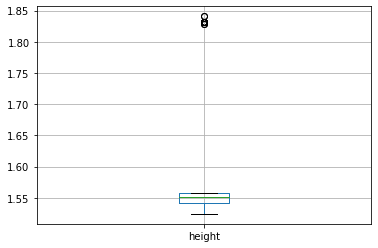

In [14]:
 df_base.boxplot(column=['height'])

<AxesSubplot:>

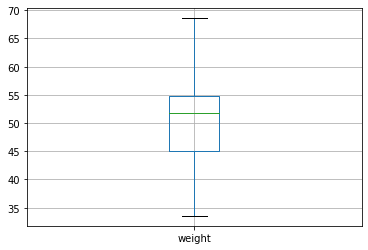

In [15]:
 df_base.boxplot(column=['weight'])

<AxesSubplot:>

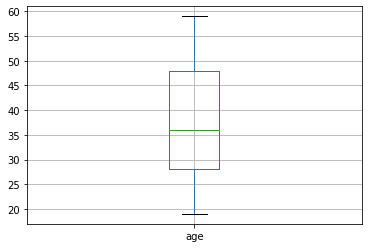

In [16]:
 df_base.boxplot(column=['age'])

<AxesSubplot:>

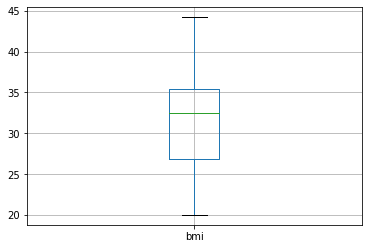

In [17]:
 df_base.boxplot(column=['bmi'])

### Model

In [18]:
#target variable
TARGET = "cost"
# primary key of an instance
PRIMARY_KEY = "app_id"
#remove strongly corr fetures for better generalization
STRONG_CORR_FEATURES = "bmi"

df_train = pd.read_csv(DataFile.TRAIN_F_NAME)
df_test = pd.read_csv(DataFile.TEST_F_NAME)
seed=45
#split test & training data
X_train =  df_train.drop([TARGET, PRIMARY_KEY, STRONG_CORR_FEATURES], axis=1)
y_train = df_train[TARGET]
X_test = df_test.drop([TARGET, PRIMARY_KEY, STRONG_CORR_FEATURES], axis=1)
y_test =  df_test[TARGET]



alpha = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = dict(alpha=alpha)

pipe = Pipeline([
    ('standard scaler', StandardScaler()),
    #('GS LR', GridSearchCV(LinearRegression(), param_grid={})),
    ('GS Lasso', GridSearchCV(estimator=Lasso(), param_grid=param_grid, scoring='r2', verbose=2, n_jobs=-1))
])
pipe.fit(X_train, y_train)
# Predict training data
y_train_pred = pipe.predict(X_train)
# Predict test data
y_test_pred = pipe.predict(X_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Predictions on training data: [428.75182756 477.91885667 522.96944493 488.00622423 561.21046757
 477.91885667 539.35845463 539.35845463 501.11743199 423.28882433
 474.89501647 428.75182756 495.65442876 412.36281786 539.35845463
 488.84486314 477.91885667 533.8954514  477.91885667 510.69687607
 537.17325334 539.35845463 439.67783403 461.52984697 423.28882433
 506.58043523 539.35845463 539.35845463 506.58043523 486.65966184
 488.84486314 466.9928502  528.43244816 539.35845463 501.11743199
 483.3818599  534.98805205 506.58043523 517.5064417  423.28882433
 533.8954514  477.91885667 456.06684373 479.26541906 539.35845463
 539.35845463 506.58043523 449.51123985 490.19142553 488.84486314
 561.21046757 539.35845463 539.35845463 566.6734708  544.82145787
 588.52548374 539.35845463 472.45585343 466.9928502 ]
Actuals on test data: 0     500.0
1     500.0
2     450.0
3     750.0
4     500.0
5     500.0
6     450.0
7     450.0
8     500.0
9     450.0
10    500.0
11    675.0
12    450.0
13    500.0


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   19.7s finished


In [19]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_test_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_test_pred))

Mean squared error: 4607.33
Coefficient of determination: 0.38


In [20]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_train, y_train_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_train, y_train_pred))

Mean squared error: 5709.90
Coefficient of determination: 0.32


#### Observation:
    While removing the outliers(IQR method) on the features - height, weight
        IQR .25, .75 lead to a negative coefficient of determination, which is a worst fit of regression line
        IQR .15, .85 lead to a positive coefficient of determination, which turned towards a good fit of regression line
    
    bmi & weight are the strongly co-related features. dropping bmi helped to move towards a good fit, where as weight havent helped.
    
